# Definitions

In [10]:
# Metrics
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import zip_longest
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
np.set_printoptions(edgeitems=1000, linewidth=100000, 
    formatter=dict(float=lambda x: "%.1f" % x))

## Formatter

In [11]:
def numfmt(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 100000)
    return s

yfmt = tkr.FuncFormatter(numfmt)

def numfmt2(x, pos): # your custom formatter function: divide y axis tick labels by 1000.0
    s = '{}'.format(x / 1000)
    return s

yfmt2 = tkr.FuncFormatter(numfmt2)

def numfmt3(x, pos): # your custom formatter function: divide y axis tick labels by 10000000.0
    s = '{}'.format(x / 10000000)
    return s
yfmt3 = tkr.FuncFormatter(numfmt3)

def numfmt4(x, pos): # your custom formatter function: multiply y axis tick labels by 100.0
    s = '{}'.format(x * 100)
    return s

yfmt4 = tkr.FuncFormatter(numfmt4)

def minutes(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 60000)
    return s

def ms_to_sec(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 1000)
    return s

def sec_to_min(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{:.2f}'.format(x / 60)
    return s

## Plotter


In [22]:
def plot_aggregated_dict(title, inputs, labels, markers, linestyles, colors, fit_degree=None, formatter=None, ylabel=None, xlabel=None, pre_fig=None):
    x = np.array(sorted(inputs[0].keys()))
    y = list(map(lambda x: np.array([]), inputs))
    lines = list()
    for key in x:
        for i, _ in enumerate(y):
            if key not in inputs[i]:
                inputs[i][key] = 0
            val = np.array(inputs[i][key])
            y[i] = np.append(y[i], val)
    fig, ax = plt.subplots() if pre_fig is None else pre_fig
    for i, yi in enumerate(y):
        if fit_degree:
            theta = np.poly1d(np.polyfit(x, y[i], fit_degree))
            fit_line = theta(x)
            lines.append(ax.scatter(x, yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i]))
            lines.append(ax.plot(x, fit_line, label=None, marker=None, linestyle=":")[0])
            
        else:
            lines.append(ax.plot(x, yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i])[0])
    if formatter is not None:
        ax.yaxis.set_major_formatter(formatter)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return (fig, ax, lines)

## Statistics Measurer

In [14]:
class MetricStatistics:
    def __init__(self, entry_folder_name="metrics", operator_name="GNN Operator - 2", metric_name="numRecordsInPerSecond", is_lambda=False):
        """ 
        Folders are organized as follows:
        entry_folder -> run -> operator_name -> metric_name -> subtask_index[digit]
        Output is as follows:
        parallelism -> experiments[] -> subtask[] -> metric_values[]
        """
        self.output = defaultdict(list)
        for run in os.listdir(entry_folder_name):
            if not os.path.isdir(os.path.join(entry_folder_name, run)):
                continue
            subtasks = []
            for subtask_index in (os.listdir(os.path.join(entry_folder_name, run, operator_name, metric_name))):
                if not subtask_index.isdigit():
                    continue
                f = pd.read_csv(os.path.join(entry_folder_name, run, operator_name, metric_name,subtask_index), header=None, names=["value"])
                subtasks.append(f["value"].values)
                
            run_class = int(re.match(".*\((\d+)\).*",run).groups()[0]) if not is_lambda else float(re.match(".*-l=(\d+.\d+).*",run).groups()[0])
            self.output[run_class].append(subtasks)
            
    def transform_metrics(self, transformation):
        """ Apply Transformation to each metric array in a subtask """
        for experiments in self.output.values():
            for experiment in experiments:
                for subtask_index in range(len(experiment)):
                    if callable(transformation):
                        experiment[subtask_index] = transformation(experiment[subtask_index])
                    elif transformation == "trim_zeros":
                        experiment[subtask_index] = np.trim_zeros(experiment[subtask_index],"fb")
                    elif transformation == "trim_zeros_back":
                        experiment[subtask_index] = np.trim_zeros(experiment[subtask_index],"b")
                    elif transformation == "trim_zeros_front":
                        experiment[subtask_index] = np.trim_zeros(experiment[subtask_index],"f")
                    elif transformation == "mean":
                        experiment[subtask_index] = np.mean(experiment[subtask_index])
                    elif transformation == "max":
                        experiment[subtask_index] = np.max(experiment[subtask_index])
                    elif transformation == "expand_dim":
                        experiment[subtask_index] = np.expand_dims(experiment[subtask_index], -1)
                        
        return self
        
    def transform_subtasks(self, transformation):
        """ Apply transformation to all subtasks """
        for experiments in self.output.values():
            for experiment_index in range(len(experiments)):
                if callable(transformation):
                    experiments[experiment_index] = transformation(experiments[experiment_index])
                elif transformation == "sum_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.sum(output, axis=0)
                elif transformation == "mean_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.mean(output, axis=0)
                elif transformation == "max_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.max(output, axis=0)
        return self
    
    def transform_experiment(self, transformation):
        """ Apply transformation to all experiments """
        for key, experiments in self.output.items():
            if callable(transformation):
                self.output[key] = transformation(experiments)
            elif transformation == "mean_0_axis":
                max_len = max([len(x) for x in experiments])
                output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments])
                self.output[key] = np.mean(output, axis=0)
            elif transformation == "max_0_axis":
                max_len = max([len(x) for x in experiments])
                output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments])
                self.output[key] = np.max(output, axis=0)
        return self
    
    def get_mean_throughput(self):
        """ Get Mean Throughput """
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("sum_0_axis")
        self.transform_subtasks(lambda x: np.array([x.mean()]))
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
    
    def get_max_throughput(self):
        """ Get Max Throughput """
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("sum_0_axis")
        self.transform_subtasks(lambda x: np.array([x.max()]))
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
        
    def get_communication_volume(self):
        """ Get Communication volume """
        self.transform_metrics("max").transform_metrics("expand_dim")
        self.transform_subtasks("sum_0_axis")
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
    
    def get_replication_factor(self):
        """ Get Partitioner Replication Factor """
        self.transform_metrics(lambda x: np.array([x[-1]]))
        self.transform_subtasks("sum_0_axis")
        self.transform_experiment("mean_0_axis")
        return self
    
    def get_runtime(self):
        """ Get runtime of this operator """
        self.transform_metrics("trim_zeros_back")
        self.transform_metrics(lambda x: np.array([x.shape[0]]))
        self.transform_subtasks("max_0_axis")
        self.transform_experiment("mean_0_axis")
        return self 

## Process Folder

(<Figure size 864x864 with 6 Axes>,
 <AxesSubplot:title={'center':'Replication Factor'}, xlabel='# Machines'>,
 [<matplotlib.lines.Line2D at 0x7f1e9e5d11c0>])

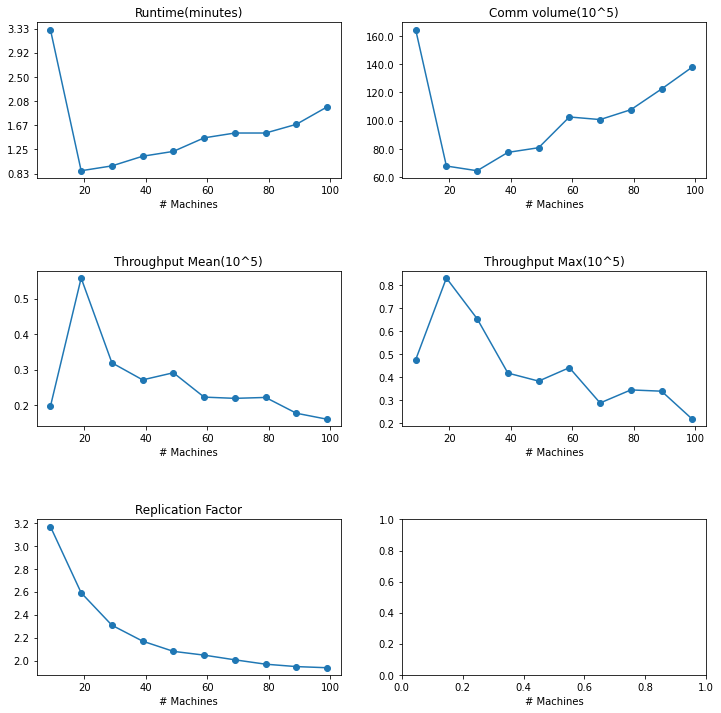

In [36]:
fig, ax = plt.subplots(3,2, figsize=(12,12), gridspec_kw={"hspace":0.6})

runtime = MetricStatistics(entry_folder_name="../../jupyter/metrics/star_expansion_metrics_window-200/", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
plot_aggregated_dict("Runtime(minutes)", [runtime.output],["D3-GNN Streaming"], ["o"], ["-"], [None], xlabel="# Machines", formatter=sec_to_min, pre_fig=(fig,ax[0][0]))

max_throughput = MetricStatistics(entry_folder_name="../../jupyter/metrics/star_expansion_metrics_window-200/", operator_name="GNN Operator - 2", metric_name="throughput").get_max_throughput()
plot_aggregated_dict("Throughput Max(10^5)", [max_throughput.output],["D3-GNN Streaming"], ["o"], ["-"], [None], xlabel="# Machines", formatter=numfmt, pre_fig=(fig,ax[1][1]))

mean_throughput = MetricStatistics(entry_folder_name="../../jupyter/metrics/star_expansion_metrics_window-200/", operator_name="GNN Operator - 2", metric_name="throughput").get_mean_throughput()
plot_aggregated_dict("Throughput Mean(10^5)", [mean_throughput.output],["D3-GNN Streaming"], ["o"], ["-"], [None], xlabel="# Machines", formatter=numfmt, pre_fig=(fig,ax[1][0]))

comm_volume = MetricStatistics(entry_folder_name="../../jupyter/metrics/star_expansion_metrics_window-200/", operator_name="IterationTail - 2", metric_name="numRecordsIn").get_communication_volume()
plot_aggregated_dict("Comm volume(10^5)", [comm_volume.output],["D3-GNN Streaming"], ["o"], ["-"], [None], xlabel="# Machines", formatter=numfmt, pre_fig=(fig,ax[0][1]))

replication_factor = MetricStatistics(entry_folder_name="../../jupyter/metrics/star_expansion_metrics_window-200/", operator_name="HDRF-1Threads", metric_name="Replication Factor").get_replication_factor()
plot_aggregated_dict("Replication Factor", [replication_factor.output],["D3-GNN Streaming"], ["o"], ["-"], [None], xlabel="# Machines", formatter=numfmt2, pre_fig=(fig,ax[2][0]))

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Replication Factor'}, xlabel='# Machines'>,
 [<matplotlib.lines.Line2D at 0x7f1ea6584ca0>])

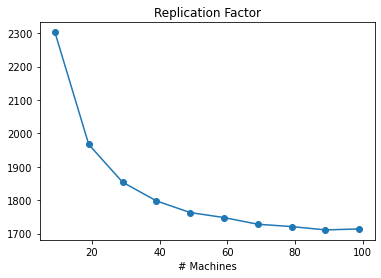

In [9]:
a = MetricStatistics(entry_folder_name="../../jupyter/metrics/star_expansion_metrics/", operator_name="HDRF-1Threads", metric_name="Replication Factor").get_replication_factor()

plot_aggregated_dict("Replication Factor", [a.output],["D3-GNN Streaming"], ["o"], ["-"], [None], xlabel="# Machines")